In [20]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import boto3
import os
import sys
import matplotlib.pyplot as plt



In [6]:
import statsmodels.api as sm

In [4]:
import pmdarima as pm

In [7]:
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [8]:
from src.preprocessing.dataset_creation.time_series_handling import time_series_to_list
from src.preprocessing.dataset_creation.missing_time_series_values_handling import MissingTimeSeriesValuesHandler

In [9]:
from label_transforms import *

In [10]:
from s3fs.core import S3FileSystem
s3 = S3FileSystem()
from sagemaker import get_execution_role

role = get_execution_role()
bucket='files-and-examples-01'
file = 'datasets/su_dataset/au_cols_a220.csv'

path = s3.open('s3://{}/{}'.format(bucket, file))

df = pd.read_csv(path)

In [11]:
df

,filename,video_id,emotion_1,emotion_1_id,frame,success,confidence,AU01_r,AU02_r,AU04_r,...,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r
0,A220_reg_p_2,A220,reg,0,1,1,1,0.00,0.0,2.10,...,1.22,0.00,1.64,0.00,0.52,0.0,0.74,0.40,0.42,0.00
1,A220_reg_p_2,A220,reg,0,2,1,1,0.00,0.0,2.11,...,1.01,0.00,1.72,0.15,0.29,0.0,0.64,0.41,0.37,0.10
2,A220_reg_p_2,A220,reg,0,3,1,1,0.00,0.0,2.06,...,0.88,0.00,1.74,0.15,0.20,0.0,0.59,0.46,0.27,0.10
3,A220_reg_p_2,A220,reg,0,4,1,1,0.00,0.0,2.06,...,0.90,0.00,1.70,0.12,0.27,0.0,0.61,0.42,0.22,0.09
4,A220_reg_p_2,A220,reg,0,5,1,1,0.00,0.0,2.03,...,0.87,0.00,1.72,0.10,0.27,0.0,0.59,0.48,0.35,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98333,A220_anx_v_3,A220,anx,34,306,1,1,0.01,0.0,0.62,...,1.37,0.61,2.10,0.00,0.78,0.0,0.95,0.03,0.00,0.00
98334,A220_anx_v_3,A220,anx,34,307,1,1,0.03,0.0,0.63,...,1.42,0.63,2.08,0.00,0.81,0.0,0.90,0.03,0.00,0.00
98335,A220_anx_v_3,A220,anx,34,308,1,1,0.03,0.0,0.55,...,1.46,0.64,2.03,0.00,0.83,0.0,0.80,0.02,0.00,0.00
98336,A220_anx_v_3,A220,anx,34,309,1,1,0.05,0.0,0.50,...,1.43,0.61,2.02,0.00,0.80,0.0,0.71,0.02,0.00,0.00


In [12]:
df[df["confidence"] == 0]

,filename,video_id,emotion_1,emotion_1_id,frame,success,confidence,AU01_r,AU02_r,AU04_r,...,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r
11030,A220_conf_p_2,A220,conf,1,1,1,0,0.0,0.0,0.85,...,0.0,0.0,0.0,5.0,0.07,0.0,2.36,0.58,0.01,0.8


In [13]:
m = MissingTimeSeriesValuesHandler()
df = m.remove_unsuccessful(df)
df = m.interpolate(df)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [14]:
ts_list = time_series_to_list(df, "filename", AU_INTENSITY_COLS, TARGET_COLUMN)

In [18]:
series = ts_list[0][0]

In [23]:
series.shape

(182, 17)

In [24]:
series_au1 = series[:, 0]

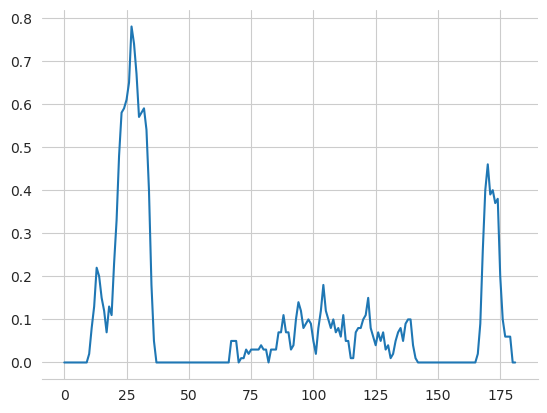

In [29]:
plt.plot(series_au1)
plt.show()

In [30]:
model = pm.auto_arima(series_au1, seasonal=True)

In [32]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  182
Model:               SARIMAX(2, 0, 2)   Log Likelihood                 360.936
Date:                Fri, 21 Oct 2022   AIC                           -709.872
Time:                        11:18:25   BIC                           -690.648
Sample:                             0   HQIC                          -702.078
                                - 182                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0111      0.011      1.058      0.290      -0.009       0.032
ar.L1          0.6861      0.074      9.326      0.000       0.542       0.830
ar.L2          0.1869      0.077      2.412      0.016       0.035       0.339
ma.L1          0.9024      0.050     18.158      0.000       0.805       1.000
ma.L2          0.8742      0.045     19.484      0.000       0.786       0.962
sigma2         0.0011   9.19e-05     11.677      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       29.96   Jarque-Bera (JB):                47.02
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                             0.40
Prob(H) (two-sided):                  0.09   Kurtosis:                         5.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
model = pm.auto_arima(series[:, 1], seasonal=True)

In [34]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  182
Model:               SARIMAX(2, 1, 3)   Log Likelihood                 369.630
Date:                Fri, 21 Oct 2022   AIC                           -727.261
Time:                        11:19:30   BIC                           -708.070
Sample:                             0   HQIC                          -719.480
                                - 182                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4050      0.065      6.261      0.000       0.278       0.532
ar.L2          0.3630      0.074      4.903      0.000       0.218       0.508
ma.L1          0.0376      0.064      0.589      0.556      -0.087       0.162
ma.L2         -0.0779      0.059     -1.316      0.188      -0.194       0.038
ma.L3         -0.8822      0.069    -12.813      0.000      -1.017      -0.747
sigma2         0.0010   6.89e-05     13.862      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       22.03   Jarque-Bera (JB):               446.97
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                             1.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
model = pm.auto_arima(series[:, 2], seasonal=True)

In [36]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  182
Model:               SARIMAX(1, 0, 2)   Log Likelihood                 462.905
Date:                Fri, 21 Oct 2022   AIC                           -917.810
Time:                        11:20:03   BIC                           -904.994
Sample:                             0   HQIC                          -912.615
                                - 182                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6983      0.027     25.671      0.000       0.645       0.752
ma.L1          1.0198      0.027     37.814      0.000       0.967       1.073
ma.L2          0.7707      0.034     22.773      0.000       0.704       0.837
sigma2         0.0004   1.38e-05     25.602      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       29.16   Jarque-Bera (JB):              1619.46
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                             0.98
Prob(H) (two-sided):                  0.21   Kurtosis:                        17.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

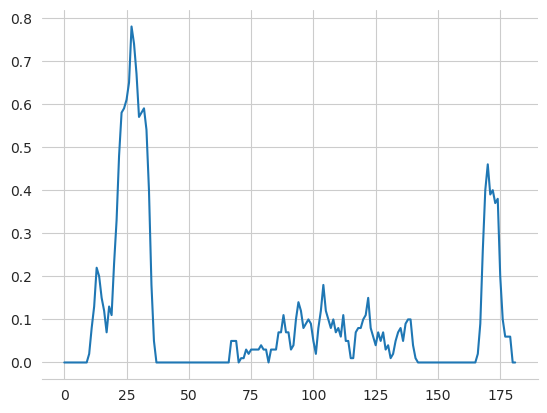

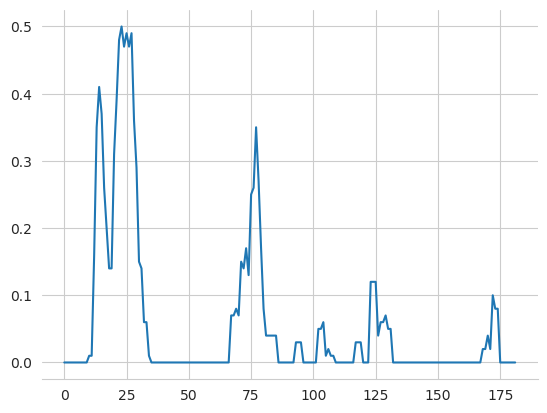

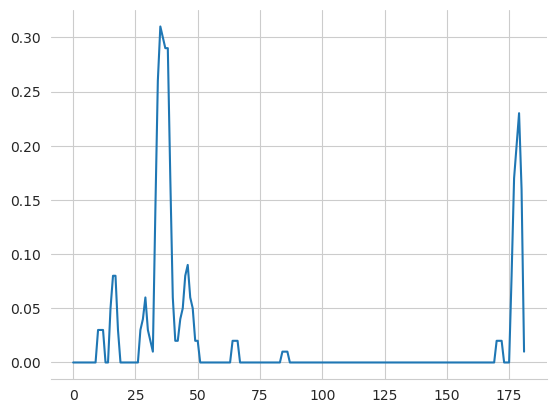

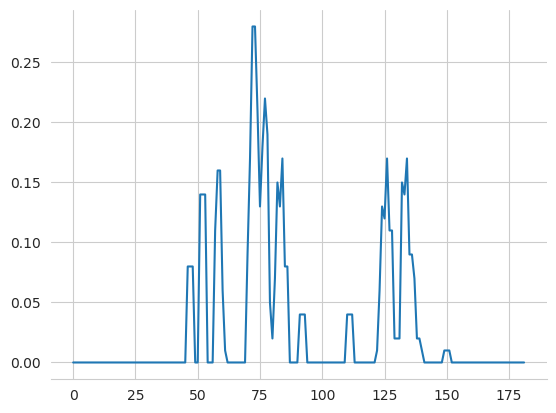

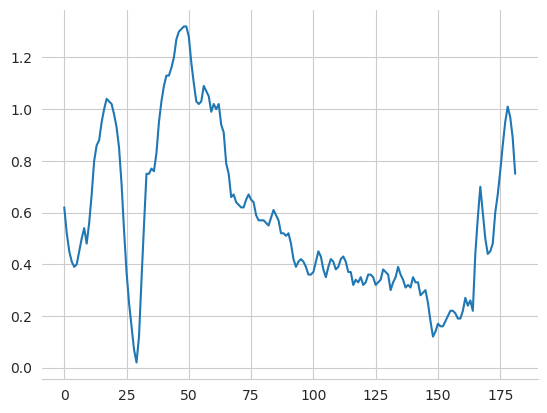

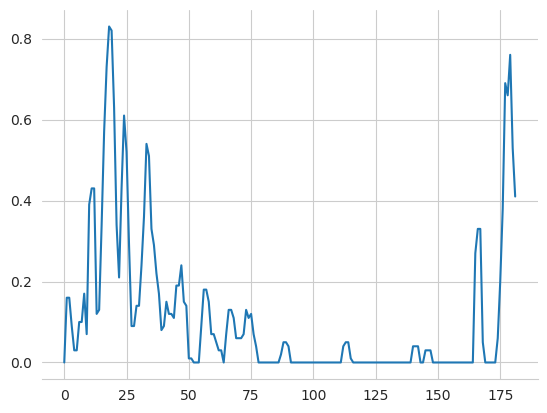

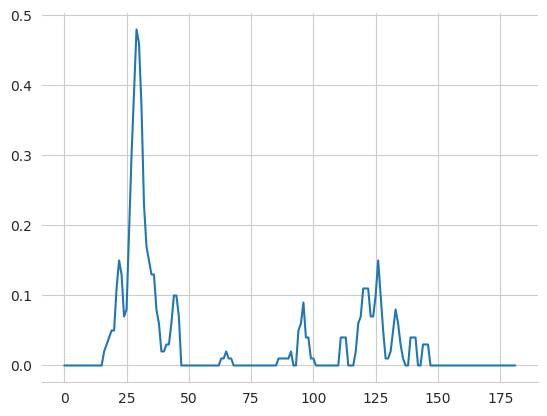

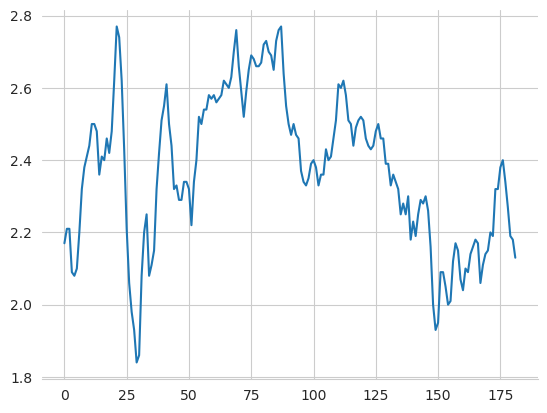

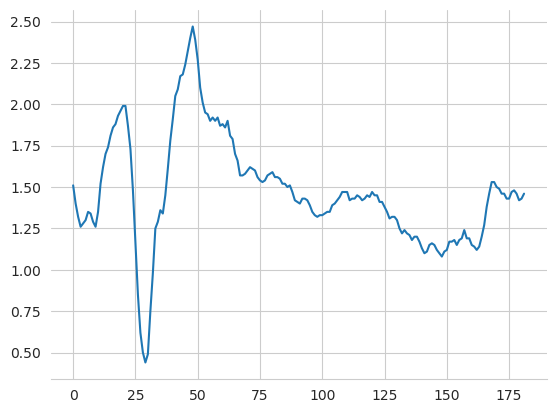

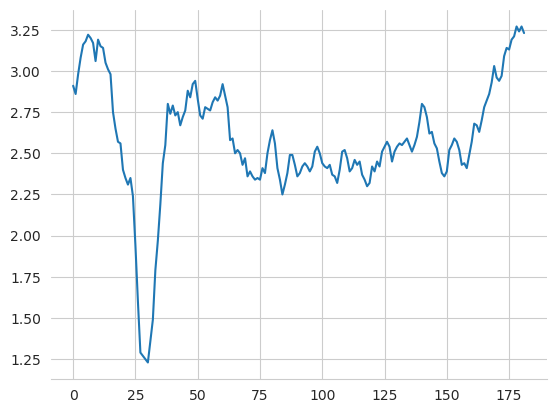

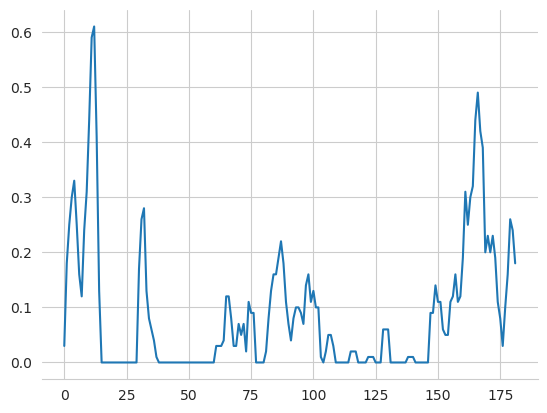

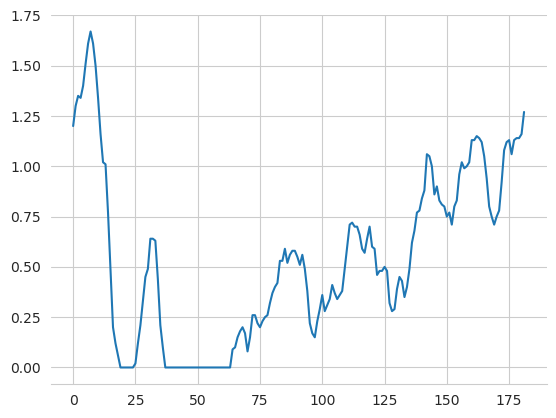

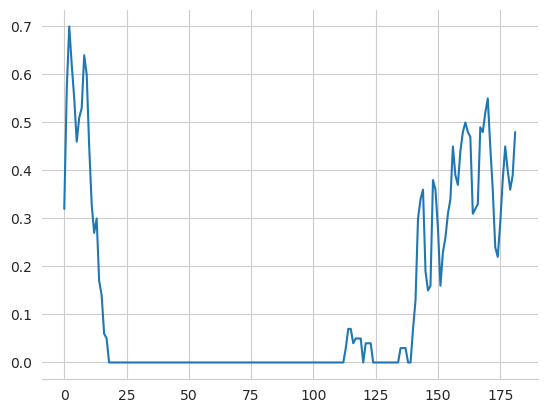

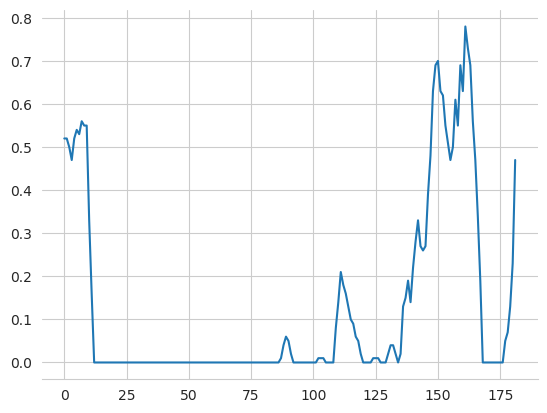

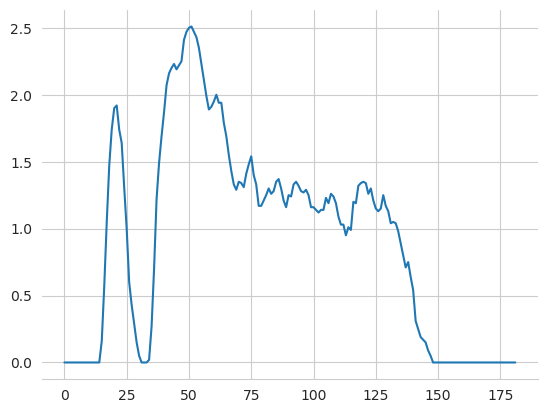

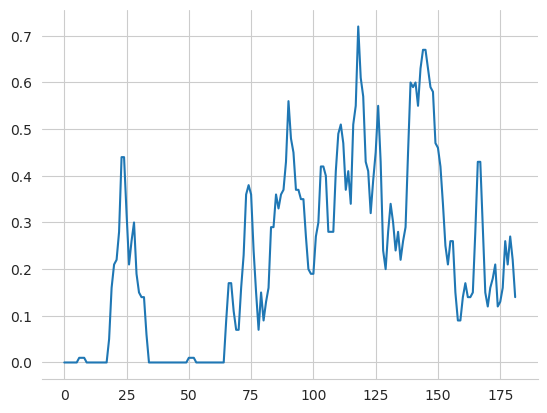

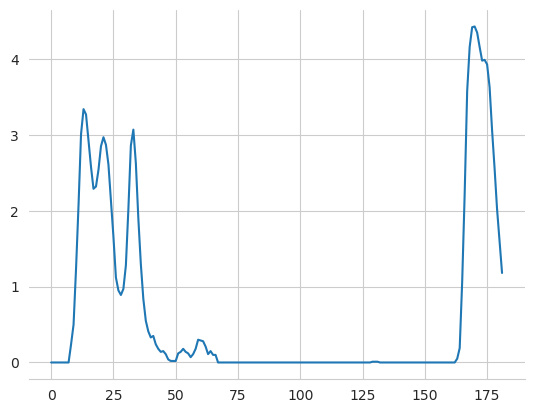

In [28]:
for i in range(series.shape[1]):
    plt.plot(series[:, i])
    plt.show()
    

In [26]:
def pad_list_of_series(ts_list):
    """
    :param ts_list: a list of time series where every element has shape (number of frames, number of features)
    :return: np.array where every element in the series has been padded with zeros and then transformed into a matrix
                with shape (number of observations, number of frames, number of features)
    """
    # obtain the longest element in the list
    length = max(map(len, ts_list))

    padded_list = []
    for series in ts_list:
        # create an empty np array of appropriate size
        pad = np.zeros((length-len(series), series.shape[1]))

        # concat with series and transpose in order to
        series = np.concatenate((series, pad))

        padded_list.append(series)

    return np.asarray(padded_list)

In [29]:
x = np.array([1, 2, 3, -1, 5])
mx = ma.masked_array(x, mask=[0, 0, 0, 1, 0])

In [30]:
mx

masked_array(data=[1, 2, 3, --, 5],
             mask=[False, False, False,  True, False],
       fill_value=999999)

In [38]:
series = ts_list[0][0]

In [40]:
series.shape

(182, 17)

In [41]:
pad = np.zeros((200-len(series), series.shape[1]))

In [43]:
pad.shape

(18, 17)

In [45]:
ma.masked_array(pad)

masked_array(
  data=[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 